Load Dataset

In [ ]:
from datasets import load_dataset

dataset_path = "train-00000-of-00010.parquet"  # Update your path
dataset = load_dataset("parquet", data_files=dataset_path)["train"]

print(dataset)


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['audio', 'text', 'gender'],
    num_rows: 1183
})


Count and hours of Dataset

In [ ]:
num_audio_files = len(dataset)

total_duration_sec = sum(audio["array"].shape[0] / audio["sampling_rate"] for audio in dataset["audio"])

total_duration_hours = total_duration_sec / 3600

print(f"Total Audio Files: {num_audio_files}")
print(f"Total Duration (hours): {total_duration_hours:.2f}")


Total Audio Files: 1183
Total Duration (hours): 2.74


In [ ]:
dataset = dataset.remove_columns(["gender"])
print(dataset)


Dataset({
    features: ['audio', 'text'],
    num_rows: 1183
})


Load the Models

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-tiny")


In [ ]:
from transformers import WhisperTokenizer

modelname = "openai/whisper-tiny"
language= "hi"  # Hindi
task = "transcribe"
tokenizer = WhisperTokenizer.from_pretrained(modelname, language=language, task=task)


In [ ]:
from transformers import WhisperProcessor

modelname = "openai/whisper-tiny"
language = "hindi"
task = "transcribe"
processor = WhisperProcessor.from_pretrained(modelname, language=language, task=task)


To convert sampling rate

In [11]:
from datasets import Audio

dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))


Function to prepae the data for model

In [ ]:
def prepare_dataset(batch, feature_extractor, tokenizer):
    audio = batch["audio"]
    
    batch["input_features"] = feature_extractor(audio["array"],
        sampling_rate=audio["sampling_rate"]).input_features[0]
    
    batch["labels"] = tokenizer(batch["text"]).input_ids
    
    return batch

Data Collator

In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass  # <-- This decorator is required
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch


data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

PreProcessing And Mapping

In [14]:
dataset = dataset.map(
    prepare_dataset,
    fn_kwargs={
        "feature_extractor": feature_extractor,
        "tokenizer": tokenizer
    },
    remove_columns=dataset.column_names,
    num_proc=2
)

Map (num_proc=2):   0%|          | 0/1183 [00:00<?, ? examples/s]

Prepare Model For Fine Tuning

In [ ]:
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainingArguments

model = WhisperForConditionalGeneration.from_pretrained(
    modelname,
    device_map="auto",
    torch_dtype=torch.float32
)

def make_inputs_require_grad(module, input, output):
    output.requires_grad_(True)
model.model.encoder.conv1.register_forward_hook(make_inputs_require_grad)

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none"
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-finetuned-hindi",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,
    warmup_steps=50,
    num_train_epochs=6,
    evaluation_strategy="no",
    fp16=False,
    per_device_eval_batch_size=8,
    generation_max_length=128,
    logging_steps=100,
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=False,
)


trainable params: 589,824 || all params: 38,350,464 || trainable%: 1.5380


In [ ]:
import os
import torch
from transformers import (
    Seq2SeqTrainer,
    TrainerCallback,
    TrainingArguments,
    TrainerState,
    TrainerControl
)
from peft import LoraConfig, get_peft_model
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR

class SavePeftModelCallback(TrainerCallback):
    def on_save(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        **kwargs,):
        checkpoint_folder = os.path.join(args.output_dir, f"{PREFIX_CHECKPOINT_DIR}-{state.global_step}")
        peft_model_path = os.path.join(checkpoint_folder, "adapter_model")
        kwargs["model"].save_pretrained(peft_model_path)
        
        pytorch_model_path = os.path.join(checkpoint_folder, "pytorch_model.bin")
        if os.path.exists(pytorch_model_path):
            os.remove(pytorch_model_path)
        return control

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset,
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    callbacks=[SavePeftModelCallback],
)

model.config.use_cache = False
trainer.train()
model.save_pretrained("./whisper-hindi-lora-final")

C:\Users\delso\AppData\Local\Temp\ipykernel_13872\83348941.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
100,1.180400
200,0.326100
300,0.241700
400,0.170600
500,0.143600
600,0.116100
700,0.086800
800,0.074500


Load Saved Model

In [ ]:
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq, pipeline
from peft import PeftModel
import torch

base_model_name = "openai/whisper-tiny"
fine_tuned_model_path = "./whisper-hindi-lora-final"

model = AutoModelForSpeechSeq2Seq.from_pretrained(base_model_name, torch_dtype=torch.float32)

model = PeftModel.from_pretrained(model, fine_tuned_model_path)
model = model.merge_and_unload()

processor = AutoProcessor.from_pretrained(base_model_name)
device = torch.device("cpu")
model.to(device)


WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 384)
      (layers): ModuleList(
        (0-3): 4 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=384, out_features=384, bias=False)
            (v_proj): Linear(in_features=384, out_features=384, bias=True)
            (q_proj): Linear(in_features=384, out_features=384, bias=True)
            (out_proj): Linear(in_features=384, out_features=384, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          

Inference

In [ ]:
import torchaudio
from torchaudio.transforms import Resample
from datasets import load_dataset

dataset_path = "train-00006-of-00010.parquet"
dataset = load_dataset("parquet", data_files=dataset_path)["train"]

num_samples = 5
samples = dataset[:num_samples]

target_sample_rate = 16000

for i, audio in enumerate(samples["audio"]):
    waveform = torch.tensor(audio["array"], dtype=torch.float32).unsqueeze(0)
    sample_rate = audio["sampling_rate"]

    
    if sample_rate != target_sample_rate:
        resampler = Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    inputs = processor(waveform.numpy(), sampling_rate=target_sample_rate, return_tensors="pt")

    with torch.no_grad():
        predicted_ids = model.generate(inputs["input_features"].to(device))

    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    print(f"Sample {i+1}: {transcription}")


Generating train split: 0 examples [00:00, ? examples/s]

Sample 1: क्यूंकी कई बार, आपके आने जानी कर आसता अलग होता है
Sample 2: फर भी थूडी कोशिश करके, आपपने वर्चुआल असिस्टिण से ये काम ली सक्पे हैं
Sample 3: आपकवृर्चुण सहयक, आपकिलिये टाईमर्सेट करने का काम्भी आस आनी से कर सक्तह है
Sample 4: बस ब कुछ छोटे से बाक्कि मैं उसको बताना है, कि मेरिल ये एक घंटे का टाइमर सेट कर दो
Sample 5: आप पने वर्चुअल साहयक से, किसी ख़ाहस दिन के लियब पूशाक चुनने में भीम मदद मांक सकते हैं


Evaulation

In [ ]:
import torch
import torchaudio
from torchaudio.transforms import Resample
from datasets import load_dataset
from transformers import AutoProcessor
from jiwer import wer, cer

dataset_path = "train-00000-of-00010.parquet"  
dataset = load_dataset("parquet", data_files=dataset_path)["train"]

processor = AutoProcessor.from_pretrained("openai/whisper-tiny")

target_sample_rate = 16000

num_samples = 5
samples = dataset[:num_samples]

wer_scores = []
cer_scores = []

for i, (audio, ground_truth) in enumerate(zip(samples["audio"], samples["text"])):
    waveform = torch.tensor(audio["array"], dtype=torch.float32).unsqueeze(0)
    sample_rate = audio["sampling_rate"]

    if sample_rate != target_sample_rate:
        resampler = Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    inputs = processor(waveform.numpy(), sampling_rate=target_sample_rate, return_tensors="pt")

    with torch.no_grad():
        predicted_ids = model.generate(inputs["input_features"].to("cpu"))  # Ensure on CPU

    predicted_text = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    sample_wer = wer(ground_truth, predicted_text)
    sample_cer = cer(ground_truth, predicted_text)

    wer_scores.append(sample_wer)
    cer_scores.append(sample_cer)

    print(f"Sample {i+1}:")
    print(f"  - Ground Truth: {ground_truth}")
    print(f"  - Predicted: {predicted_text}")
    print(f"  - WER: {sample_wer:.4f}")
    print(f"  - CER: {sample_cer:.4f}\n")

avg_wer = sum(wer_scores) / num_samples
avg_cer = sum(cer_scores) / num_samples

print(f"Average WER: {avg_wer:.4f}")
print(f"Average CER: {avg_cer:.4f}")


Sample 1:
  - Ground Truth: प्रसिद्द कबीर अध्येता, पुरुषोत्तम अग्रवाल का यह शोध आलेख, उस रामानंद की खोज करता है
  - Predicted: प्रसिद्ध कबीर अध्येता, पुरुषोत्तम अग्रवाल का यह शोध आलेख, उस रामानंद की खोज करता है
  - WER: 0.0667
  - CER: 0.0120

Sample 2:
  - Ground Truth: किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राह्मण रामानंद के, एक जुलाहे कबीर का गुरु होने से, बल्कि दोनों के समकालीन होने से भी, इनकार करता है
  - Predicted: किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राम्मण रामानंद के, एक जुलाहे कबीर का गुरु होने से, बल्कि दोनों के समकालीन होने से भी, इनकार करता है
  - WER: 0.0769
  - CER: 0.0219

Sample 3:
  - Ground Truth: उस पर, इन चार कवियों का गहरा असर है
  - Predicted: उस पर, इन चार कवियों का गहरा असर है
  - WER: 0.0000
  - CER: 0.0000

Sample 4:
  - Ground Truth: इसे कई बार मंचित भी किया गया है
  - Predicted: इसे कई बार मंचित भी किया गया है
  - WER: 0.0000
  - CER: 0.0000

Sample 5:
  - Ground Truth: यहाँ प्रस्तुत है, हिन्दी कवि कथाकार, तेजी ग्रोवर के अंग्रेज़ी के मार्फ़त किए गए अनुवाद के

In [1]:
import os

def get_folder_size(path):
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total += os.path.getsize(fp)
    return total / (1024 ** 2)  # in MB

lora_path = "./whisper-hindi-lora-final"
lora_size = get_folder_size(lora_path)
print(f"LoRA Adapter Size on Disk: {lora_size:.2f} MB")


LoRA Adapter Size on Disk: 2.26 MB


In [ ]:
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
from peft import PeftModel
import torch
import os

base_model_name = "openai/whisper-tiny"
fine_tuned_model_path = "./whisper-hindi-lora-final"

model = AutoModelForSpeechSeq2Seq.from_pretrained(base_model_name, torch_dtype=torch.float32)
model = PeftModel.from_pretrained(model, fine_tuned_model_path)
model = model.merge_and_unload()

merged_path = "./merged-whisper-hindi"
model.save_pretrained(merged_path)

merged_size = get_folder_size(merged_path)
print(f"Merged Model Size on Disk: {merged_size:.2f} MB")


The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
C:\Users\delso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\modeling_utils.py:2810: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You 

Merged Model Size on Disk: 144.07 MB


In [ ]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("openai/whisper-tiny")
processor.save_pretrained("./merged-whisper-hindi")


[]

In [ ]:
import torch
import torchaudio
from torchaudio.transforms import Resample
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
from jiwer import wer, cer

dataset_path = "train-00000-of-00010.parquet"  
dataset = load_dataset("parquet", data_files=dataset_path)["train"]

merged_model_path = "./merged-whisper-hindi"
model = AutoModelForSpeechSeq2Seq.from_pretrained(merged_model_path)
processor = AutoProcessor.from_pretrained(merged_model_path)

device = torch.device("cpu")
model.to(device)

target_sample_rate = 16000
num_samples = 5
samples = dataset[:num_samples]

wer_scores = []
cer_scores = []

for i, (audio, ground_truth) in enumerate(zip(samples["audio"], samples["text"])):
    waveform = torch.tensor(audio["array"], dtype=torch.float32).unsqueeze(0)
    sample_rate = audio["sampling_rate"]

    if sample_rate != target_sample_rate:
        resampler = Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    inputs = processor(waveform.numpy(), sampling_rate=target_sample_rate, return_tensors="pt")

    with torch.no_grad():
        predicted_ids = model.generate(inputs["input_features"].to(device))

    predicted_text = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    sample_wer = wer(ground_truth, predicted_text)
    sample_cer = cer(ground_truth, predicted_text)

    wer_scores.append(sample_wer)
    cer_scores.append(sample_cer)

    print(f"Sample {i+1}:")
    print(f"  - Ground Truth: {ground_truth}")
    print(f"  - Predicted:    {predicted_text}")
    print(f"  - WER: {sample_wer:.4f}")
    print(f"  - CER: {sample_cer:.4f}\n")

avg_wer = sum(wer_scores) / num_samples
avg_cer = sum(cer_scores) / num_samples

print(f"Average WER: {avg_wer:.4f}")
print(f"Average CER: {avg_cer:.4f}")


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Sample 1:
  - Ground Truth: प्रसिद्द कबीर अध्येता, पुरुषोत्तम अग्रवाल का यह शोध आलेख, उस रामानंद की खोज करता है
  - Predicted:    प्रसिद्ध कबीर अध्येता, पुरुषोत्तम अग्रवाल का यह शोध आलेख, उस रामानंद की खोज करता है
  - WER: 0.0667
  - CER: 0.0120

Sample 2:
  - Ground Truth: किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राह्मण रामानंद के, एक जुलाहे कबीर का गुरु होने से, बल्कि दोनों के समकालीन होने से भी, इनकार करता है
  - Predicted:    किन्तु आधुनिक पांडित्य, न सिर्फ़ एक ब्राम्मण रामानंद के, एक जुलाहे कबीर का गुरु होने से, बल्कि दोनों के समकालीन होने से भी, इनकार करता है
  - WER: 0.0769
  - CER: 0.0219

Sample 3:
  - Ground Truth: उस पर, इन चार कवियों का गहरा असर है
  - Predicted:    उस पर, इन चार कवियों का गहरा असर है
  - WER: 0.0000
  - CER: 0.0000

Sample 4:
  - Ground Truth: इसे कई बार मंचित भी किया गया है
  - Predicted:    इसे कई बार मंचित भी किया गया है
  - WER: 0.0000
  - CER: 0.0000

Sample 5:
  - Ground Truth: यहाँ प्रस्तुत है, हिन्दी कवि कथाकार, तेजी ग्रोवर के अंग्रेज़ी के मार्फ़त किए 

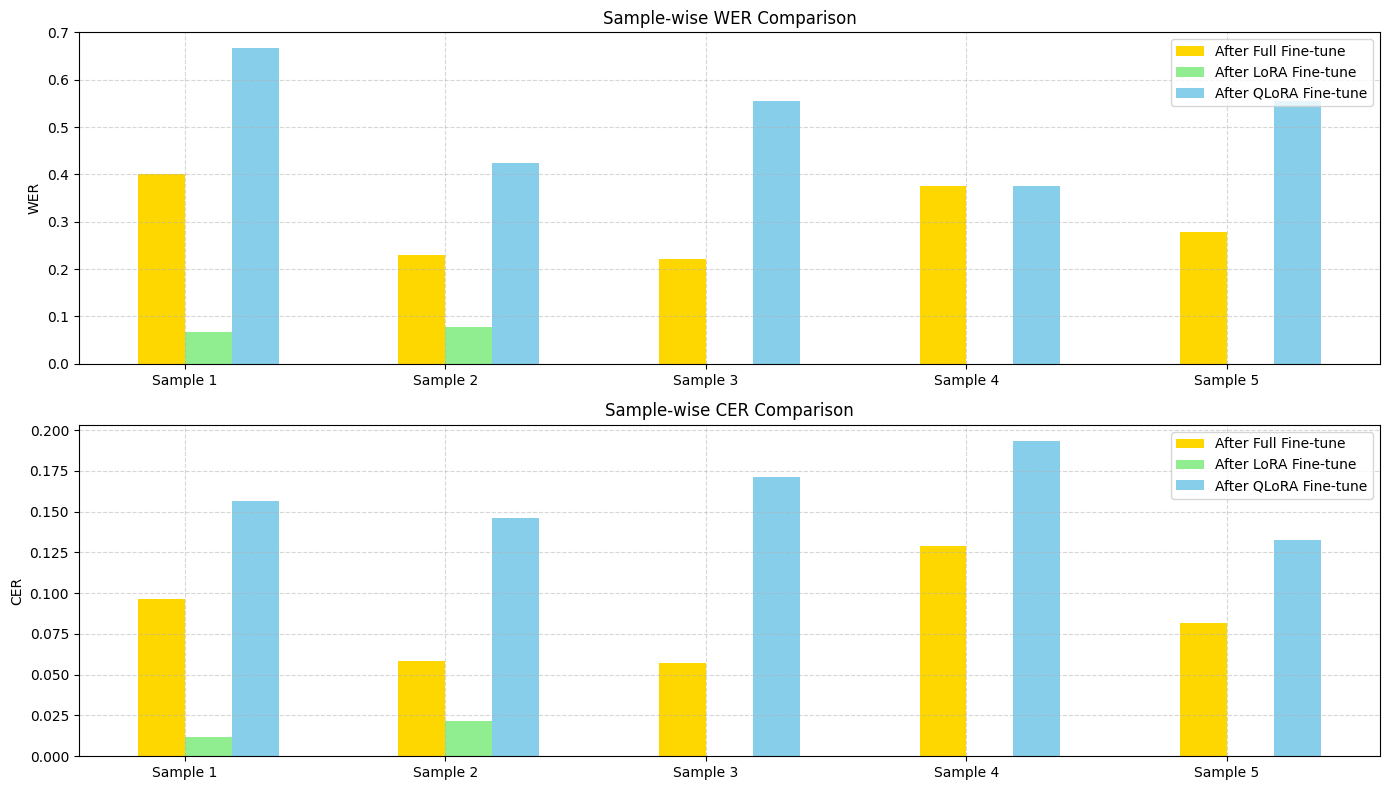

In [5]:
import matplotlib.pyplot as plt
import numpy as np

samples = [f"Sample {i}" for i in range(1, 6)]


wer_after_full = [0.4000, 0.2308, 0.2222, 0.3750, 0.2778]
cer_after_full = [0.0964, 0.0584, 0.0571, 0.1290, 0.0816]

wer_after_lora = [0.0667, 0.0769, 0.0000, 0.0000, 0.0000]
cer_after_lora = [0.0120, 0.0219, 0.0000, 0.0000, 0.0000]

wer_after_qlora = [0.6667, 0.4231, 0.5556, 0.3750, 0.5556]
cer_after_qlora = [0.1566, 0.1460, 0.1714, 0.1935, 0.1327]

x = np.arange(len(samples))  # [0, 1, 2, 3, 4]
width = 0.18

fig, axs = plt.subplots(2, 1, figsize=(14, 8))
plt.subplots_adjust(hspace=0.4)

# --- WER Plot ---
axs[0].bar(x - 0.5*width, wer_after_full, width, label='After Full Fine-tune', color='gold')
axs[0].bar(x + 0.5*width, wer_after_lora, width, label='After LoRA Fine-tune', color='lightgreen')
axs[0].bar(x + 1.5*width, wer_after_qlora, width, label='After QLoRA Fine-tune', color='skyblue')

axs[0].set_ylabel('WER')
axs[0].set_title('Sample-wise WER Comparison')
axs[0].set_xticks(x)
axs[0].set_xticklabels(samples)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# --- CER Plot ---

axs[1].bar(x - 0.5*width, cer_after_full, width, label='After Full Fine-tune', color='gold')
axs[1].bar(x + 0.5*width, cer_after_lora, width, label='After LoRA Fine-tune', color='lightgreen')
axs[1].bar(x + 1.5*width, cer_after_qlora, width, label='After QLoRA Fine-tune', color='skyblue')

axs[1].set_ylabel('CER')
axs[1].set_title('Sample-wise CER Comparison')
axs[1].set_xticks(x)
axs[1].set_xticklabels(samples)
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [2]:
import torch
import torchaudio
from torchaudio.transforms import Resample
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq
from jiwer import wer, cer

dataset_path = "train-00006-of-00010.parquet"  
dataset = load_dataset("parquet", data_files=dataset_path)["train"]

merged_model_path = "./merged-whisper-hindi"
model = AutoModelForSpeechSeq2Seq.from_pretrained(merged_model_path)
processor = AutoProcessor.from_pretrained(merged_model_path)

device = torch.device("cpu")
model.to(device)

target_sample_rate = 16000
num_samples = 5
samples = dataset[:num_samples]

wer_scores = []
cer_scores = []

for i, (audio, ground_truth) in enumerate(zip(samples["audio"], samples["text"])):
    waveform = torch.tensor(audio["array"], dtype=torch.float32).unsqueeze(0)
    sample_rate = audio["sampling_rate"]

    if sample_rate != target_sample_rate:
        resampler = Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    inputs = processor(waveform.numpy(), sampling_rate=target_sample_rate, return_tensors="pt")

    with torch.no_grad():
        predicted_ids = model.generate(inputs["input_features"].to(device))

    predicted_text = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    sample_wer = wer(ground_truth, predicted_text)
    sample_cer = cer(ground_truth, predicted_text)

    wer_scores.append(sample_wer)
    cer_scores.append(sample_cer)

    print(f"Sample {i+1}:")
    print(f"  - Ground Truth: {ground_truth}")
    print(f"  - Predicted:    {predicted_text}")
    print(f"  - WER: {sample_wer:.4f}")
    print(f"  - CER: {sample_cer:.4f}\n")

avg_wer = sum(wer_scores) / num_samples
avg_cer = sum(cer_scores) / num_samples

print(f"Average WER: {avg_wer:.4f}")
print(f"Average CER: {avg_cer:.4f}")


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Sample 1:
  - Ground Truth: क्योंकि कई बार, आपके आने-जाने का रास्ता अलग होता है.
  - Predicted:    क्यूंकी कई बार, आपके आने जानी कर आसता अलग होता है
  - WER: 0.6000
  - CER: 0.1731

Sample 2:
  - Ground Truth: फिर भी थोड़ी कोशिश करके, आप अपने वर्चुअल असिस्टेंट से ये काम ले सकते हैं.
  - Predicted:    फर भी थूडी कोशिश करके, आपपने वर्चुआल असिस्टिण से ये काम ली सक्पे हैं
  - WER: 0.6000
  - CER: 0.1781

Sample 3:
  - Ground Truth: आपका वर्चुअल सहायक, आपके लिए टाइमर सेट करने का काम भी आसानी से कर सकता है.
  - Predicted:    आपकवृर्चुण सहयक, आपकिलिये टाईमर्सेट करने का काम्भी आस आनी से कर सक्तह है
  - WER: 0.7500
  - CER: 0.2432

Sample 4:
  - Ground Truth: बस आपको छोटे से वाक्य में उसको बताना है, कि मेरे लिए एक घंटे का टाइमर सेट कर दो.
  - Predicted:    बस ब कुछ छोटे से बाक्कि मैं उसको बताना है, कि मेरिल ये एक घंटे का टाइमर सेट कर दो
  - WER: 0.3684
  - CER: 0.1750

Sample 5:
  - Ground Truth: आप अपने वर्चुअल सहायक से, किसी ख़ास दिन के लिए पोशाक चुनने में भी मदद मांग सकते हैं.
  - Predicted:

In [3]:
import shutil

# Specify the directory and the zip file name
model_dir = './whisper-hindi-lora-final'
zip_filename = './whisper-hindi-lora-final.zip'

# Create a zip file
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', model_dir)


'c:\\Users\\delso\\whisperlora\\whisper-hindi-lora-final.zip'